In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import plotly.express as px
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import mplcursors
from wordcloud import WordCloud
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Se establece la ruta del archivo Parquet
archivo2023 = 'C:/Users/User/Desktop/PF_NYC_CO2/Taxi/Taxi_2023_Unificado.parquet'
# Se lee el archivo Parquet y se configura la  opcion de lectura para optimizar la memoria
tabla_parquet = pq.read_table(archivo2023, use_threads=True)
# Se convierte la tabla a un DataFrame de pandas y se libera la memoria utilizada por la tabla Parquet
df_Taxi_2023 = tabla_parquet.to_pandas()

In [3]:
df_Taxi_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32838778 entries, 0 to 32838777
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   PULocationID        int64         
 1   Borough             object        
 2   Zone                object        
 3   Service_Zone        object        
 4   Passenger_Count     float64       
 5   Trip_Distance       float64       
 6   DOLocationID        int64         
 7   RatecodeID          float64       
 8   Store_and_fwd_flag  object        
 9   Total_Amount        float64       
 10  Date_pickup         datetime64[ns]
 11  Time_pickup         datetime64[ns]
 12  Date_dropoff        datetime64[ns]
 13  Time_dropoff        datetime64[ns]
dtypes: datetime64[ns](4), float64(4), int64(2), object(4)
memory usage: 3.4+ GB


### Diccionario
* PULocationID: Zona de taxis en la que se activó el taxímetro
* Borough:      Distrito
* Zone:         Zona
* Service_Zone: Zona de servicio
* Passenger_Count: El número de pasajeros en el vehículo.
* Trip_Distance: La distancia de viaje transcurrida en millas informada por el taxímetro.	
* DOLocationID:  Zona de taxis de TLC en la que se desactivó el taxímetro
* RatecodeID:	   El código de tarifa final vigente al final del viaje.
* Store_and_fwd_flag:	Esta marca indica si el registro de viaje se mantuvo en la memoria del vehículo antes de enviarlo al proveedor, también conocido como "almacenar y reenviar", porque el vehículo no tenía conexión con el servidor.
* Total_Amount: El importe total cobrado a los pasajeros. No incluye propinas en efectivo.	
* Date_pickup:  Fecha de recogida
* Time_pickup:  Hora de recogida
* Date_dropoff: Fecha de finalización 
* Time_dropoff: Hora de finalización

In [4]:
df_Taxi_2023['Date_pickup'].value_counts()

Date_pickup
2023-05-18    126918
2023-05-17    124953
2023-11-16    123477
2023-05-11    122929
2023-10-26    121716
               ...  
2001-01-01         6
2003-01-01         6
2022-10-25         6
2023-12-01         3
2014-11-19         1
Name: count, Length: 343, dtype: int64

In [5]:
# Se eliminan las filas donde los valores de la columna Date_pickup es diferente al año 2023
df_Taxi_2023['Date_pickup'] = pd.to_datetime(df_Taxi_2023['Date_pickup'])
# Filtrar los datos para mantener solo los del año 2023
df_Taxi_2023 = df_Taxi_2023[df_Taxi_2023['Date_pickup'].dt.year == 2023]

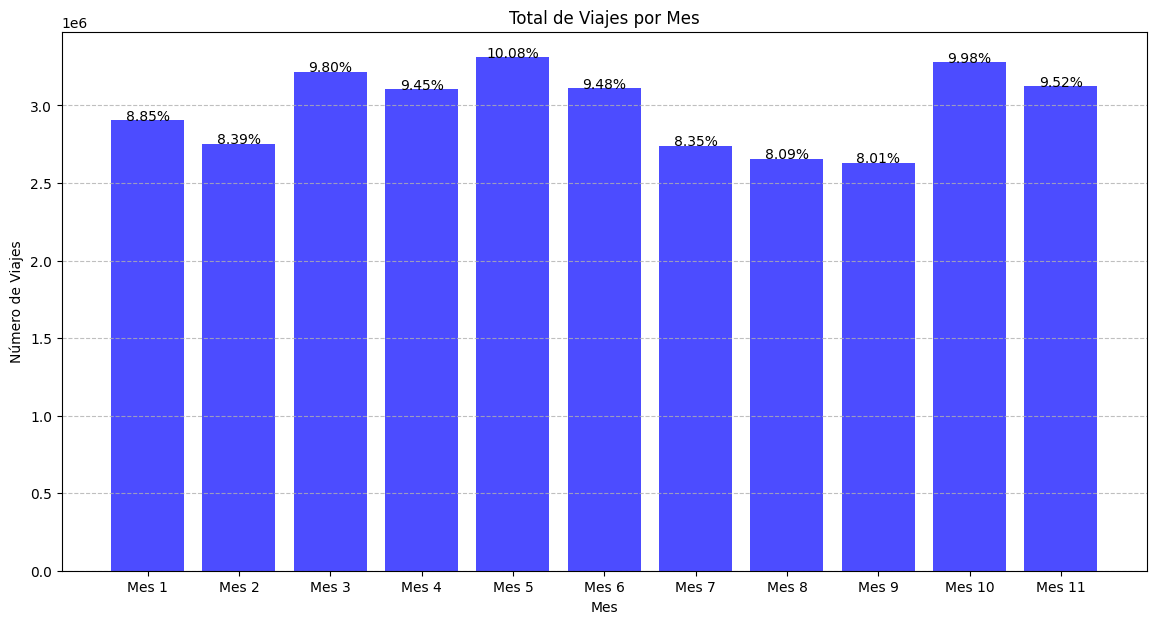

In [6]:
# Extraer el mes de recogida del servicio
df_Taxi_2023['Month_pickup'] = df_Taxi_2023['Date_pickup'].dt.month

# Crear un histograma de viajes por mes
plt.figure(figsize=(14, 7))
n, bins, patches = plt.hist(df_Taxi_2023['Month_pickup'], bins=11, rwidth=0.8, alpha=0.7, color='blue', align='left')

# Ajustar la alineación del gráfico
plt.title('Total de Viajes por Mes')
plt.xlabel('Mes')
plt.ylabel('Número de Viajes')
plt.xticks(range(1, 12), [f'Mes {i}' for i in range(1, 12)], ha='center')  # Etiquetas del eje x centradas
plt.grid(axis='y', linestyle='--', alpha=0.8)

# Agregar el porcentaje encima de cada barra
total_viajes = len(df_Taxi_2023)
for i, patch in enumerate(patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height + 5, f'{(height / total_viajes):.2%}', ha='center')

plt.show()

#### Analisis total viajes por mes.
En este gráfico se puede observar que los meses de marzo, octubre y mayo son los meses con mayor cantidad de viajes en la ciudad de Nueva York. Sin embargo, la diferencia con los otros meses no es muy significativa, lo que sugiere que la toma de servicios de taxi en la ciudad es constante.

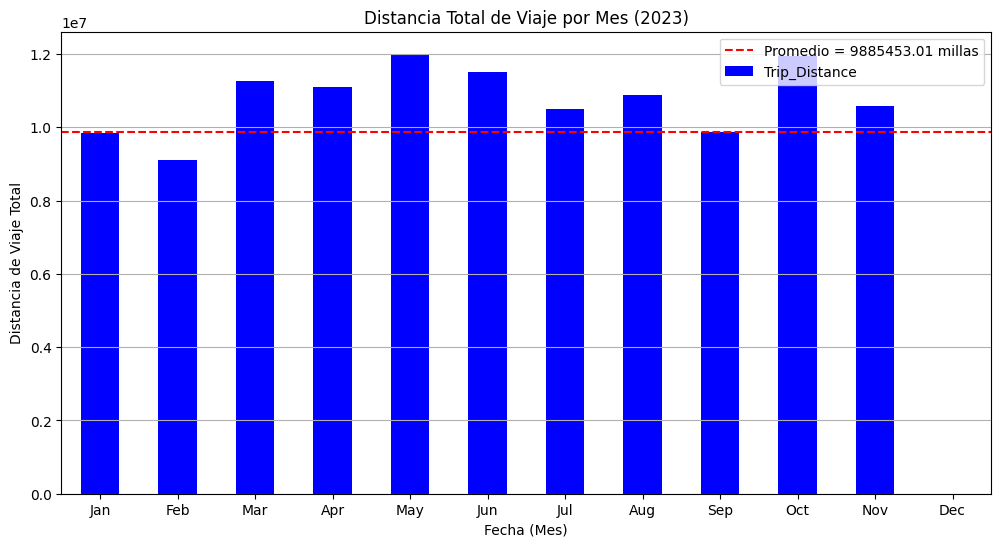

In [18]:
# Se agrupan los datos por mes y suma la distancia de viaje
distancia_total_mensual = df_Taxi_2023.groupby(df_Taxi_2023['Date_pickup'].dt.to_period('M'))['Trip_Distance'].sum()

# Se calcula la distancia total
distancia_total = distancia_total_mensual.sum()

# Se calcula el promedio
distancia_promedio = distancia_total / len(distancia_total_mensual)

# Se crea un gráfico de barras
plt.figure(figsize=(12, 6))
distancia_total_mensual.plot(kind='bar', color='blue')

# Se ajustan las etiquetas.
etiquetas_mes = [mes.strftime('%b') for mes in distancia_total_mensual.index.to_timestamp()]
plt.xticks(range(len(distancia_total_mensual)), etiquetas_mes, rotation=0)

# Se agrega una línea horizontal para indicar el promedio
plt.axhline(y=distancia_promedio, color='red', linestyle='--', label=f'Promedio = {round(distancia_promedio, 2)} millas')

plt.title('Distancia Total de Viaje por Mes (2023)')
plt.xlabel('Fecha (Mes)')
plt.ylabel('Distancia de Viaje Total')
plt.legend()
plt.grid(axis='y')
plt.show()

#### Analisis Total distancia de viajes por mes.
En este gráfico revela que los meses de mayo y octubre se destacan como periodos con una mayor distancia total de viaje en la ciudad de Nueva York. Aunque estos meses indican un aumento en la demanda de servicios de taxi, la diferencia con otros meses no es muy significativa. Esto sugiere que, a pesar de las variaciones estacionales, la toma de servicios de taxi en la ciudad se mantiene relativamente constante, indicando una cierta estabilidad en la demanda a lo largo del año.

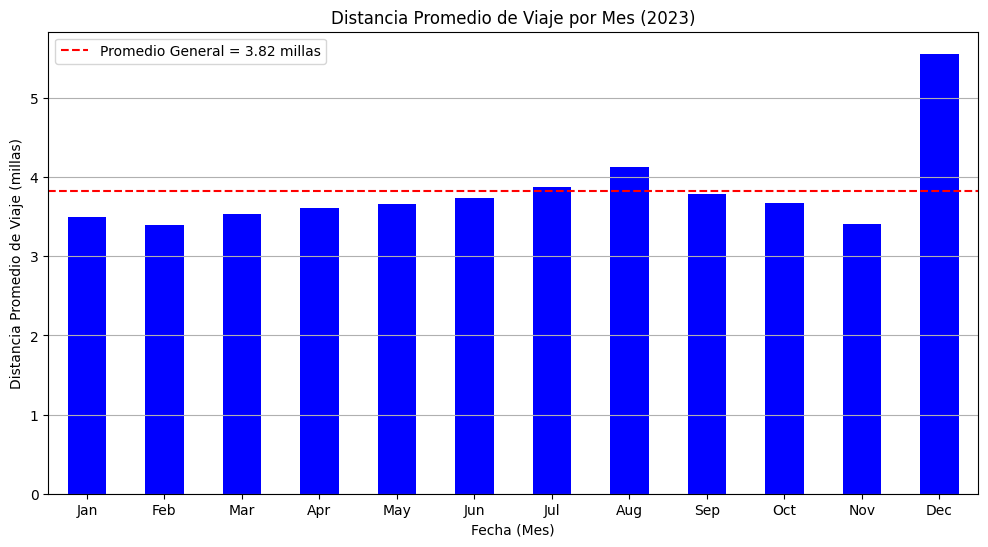

In [8]:
# Agrupar los datos por mes y sumar la distancia de viaje
monthly_total_distance = df_Taxi_2023.groupby(df_Taxi_2023['Date_pickup'].dt.to_period('M'))['Trip_Distance'].sum()

# Agrupar los datos por mes y contar la cantidad de viajes
monthly_trip_count = df_Taxi_2023.groupby(df_Taxi_2023['Date_pickup'].dt.to_period('M')).size()

# Calcular la distancia promedio por mes
monthly_avg_distance = monthly_total_distance / monthly_trip_count

# Calcular el promedio general de distancia por mes
overall_avg_distance = monthly_avg_distance.mean()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
monthly_avg_distance.plot(kind='bar', color='blue')

# Dibujar una línea horizontal para indicar el promedio general
plt.axhline(y=overall_avg_distance, color='red', linestyle='--', label=f'Promedio General = {round(overall_avg_distance, 2)} millas')

# Ajustar las etiquetas del eje x para mostrar solo el mes
month_labels = [month.strftime('%b') for month in monthly_avg_distance.index.to_timestamp()]
plt.xticks(range(len(monthly_avg_distance)), month_labels, rotation=0)

plt.title('Distancia Promedio de Viaje por Mes (2023)')
plt.xlabel('Fecha (Mes)')
plt.ylabel('Distancia Promedio de Viaje (millas)')
plt.legend()
plt.grid(axis='y')
plt.show()

#### Analisis Distancia promedio de viaje (millas)
En el gráfico presentado, se puede observar que la distancia promedio de viaje en la ciudad de Nueva York es de 3.82 millas. Los meses de agosto y diciembre son los meses en los que se observa una distancia por encima del promedio. En particular, el mes de diciembre es el mes en el que se aumentan las distancias promedio de viaje. Los otros meses mantienen una constante de la media. podemos concluir que la distancias recorridas por los taxista 

In [10]:
# Se validan los valores de la columna Borough.
df_Taxi_2023['Borough'].unique()
# Se eliminan las filas donde los valores de la columna Borough igual a Unknow
df_Taxi_2023 = df_Taxi_2023[df_Taxi_2023['Borough'] != 'Unknown']

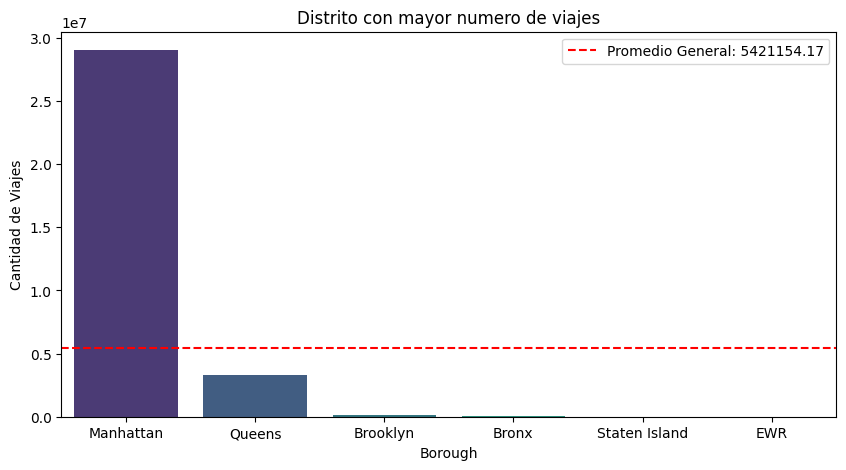

In [11]:
# Se agrupo por distrito y se calcuala la frecuencia
viajes_por_distrito = df_Taxi_2023['Borough'].value_counts().reset_index()
# Se renombran las columnas para mayor claridad
viajes_por_distrito.columns = ['Borough', 'Cantidad de Viajes']
# Se ordenan los distritos por la cantidad de viajes en orden descendente
viajes_por_distrito = viajes_por_distrito.sort_values(by='Cantidad de Viajes', ascending=False)
# Se calcula el promedio general de viajes por distrito
promedio_general = viajes_por_distrito['Cantidad de Viajes'].mean()
# Se crea un gráfico de barras
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Borough', y='Cantidad de Viajes', data=viajes_por_distrito, palette='viridis')
plt.title('Distrito con mayor numero de viajes')
plt.xlabel('Borough')
plt.ylabel('Cantidad de Viajes')
# Se ajusta la alineación del texto en el eje x para centrar los nombres del distrito
plt.xticks(rotation=0, ha='center')
# Se agrega la línea roja para el promedio general
plt.axhline(y=promedio_general, color='red', linestyle='--', label=f'Promedio General: {promedio_general:.2f}')
plt.legend()

plt.show()



#### Analisis Distritro con mayor numero de viajes
En el gráfico se muestra que el distrito de Manhattan es el lugar de partida y destino más elegido para los viajes en la ciudad de Nueva York, abarcando casi el 90% del total de viajes que se realizan en la ciudad

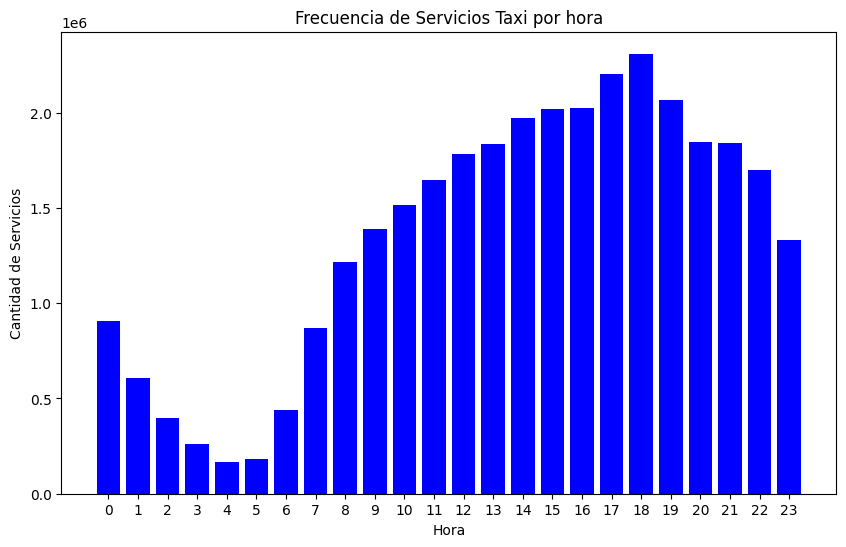

In [12]:
# Se crear grafico de barra para frecuencia de servicios por hora.
# Se agrupa por hora y se cuenta la frecuencia
cantidad_servicios = df_Taxi_2023.groupby(df_Taxi_2023['Time_pickup'].dt.hour).size().reset_index(name='Cantidad de Servicios')

# Crear un gráfico de barras con Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(cantidad_servicios['Time_pickup'], cantidad_servicios['Cantidad de Servicios'], color='blue', linewidth=1.5)
plt.title('Frecuencia de Servicios Taxi por hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad de Servicios')
plt.xticks(range(24), rotation=0)
plt.show()

#### Analisis Frecuencia de servicios por hora.
En este grafico podemos observar que la frecuencia de servicios de taxi es mayor en las horas pico(17-19), es decir, en las horas en que la gente se dirige al trabajo o regresa a casa.

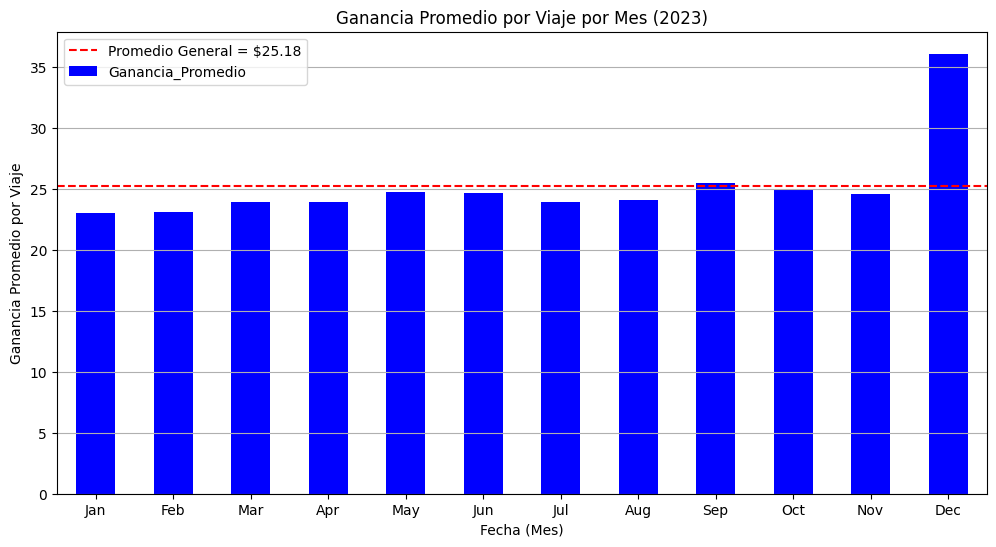

In [13]:
# Se crea una nueva columna para la ganancia promedio por viaje
df_Taxi_2023['Ganancia_Promedio'] = df_Taxi_2023['Total_Amount'] / df_Taxi_2023['Passenger_Count']
# Se calcula la ganancia promedio por viaje para cada mes
monthly_avg_profit = df_Taxi_2023.groupby(df_Taxi_2023['Date_pickup'].dt.to_period('M'))['Ganancia_Promedio'].mean()
# Se calcula el promedio general de ganancia por mes
overall_avg_profit = monthly_avg_profit.mean()
# Se crea el gráfico de barras
plt.figure(figsize=(12, 6))
monthly_avg_profit.plot(kind='bar', color='blue')
# Se dibuja una línea horizontal para indicar el promedio general
plt.axhline(y=overall_avg_profit, color='red', linestyle='--', label=f'Promedio General = ${round(overall_avg_profit, 2)}')
# Se ajustan las etiquetas del eje x para mostrar solo el mes
month_labels = [month.strftime('%b') for month in monthly_avg_profit.index.to_timestamp()]
plt.xticks(range(len(monthly_avg_profit)), month_labels, rotation=0)
plt.title('Ganancia Promedio por Viaje por Mes (2023)')
plt.xlabel('Fecha (Mes)')
plt.ylabel('Ganancia Promedio por Viaje')
plt.legend() 
plt.grid(axis='y')
plt.show()

#### Analisis garancia promedio por Viaje 
El gráfico muestra que la ganancia promedio por viaje es de 25.18 dolares y es mayor en el mes de Diciembre Además, se puede observar que la ganancia promedio por viaje mas baja se presenta en los meses de Enero y Febrero

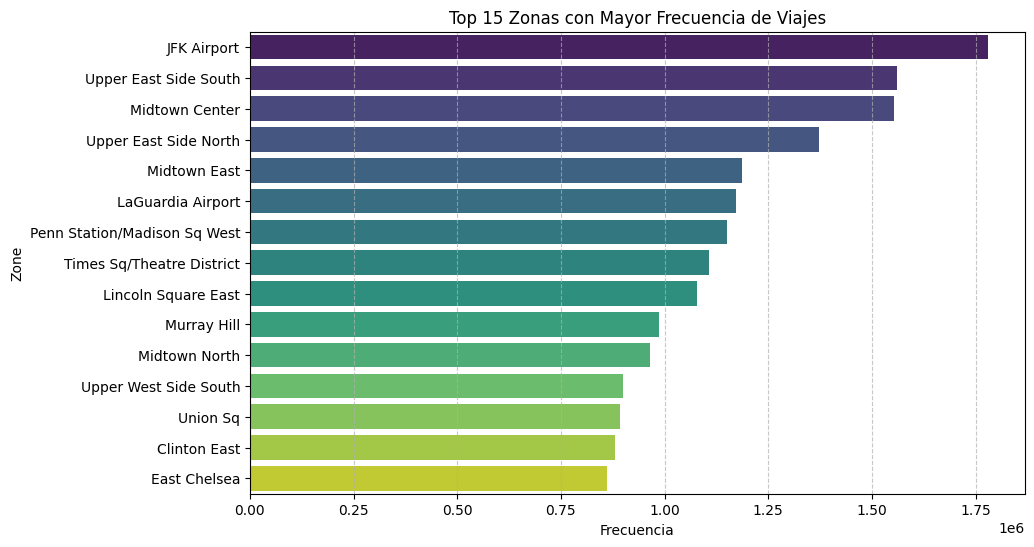

In [14]:
# Se muestra el top 15 de de las zonas con mayor frecuancia de viajes
# Se cuenta la frecuencia de viajes en cada zona
zone_counts = df_Taxi_2023['Zone'].value_counts()
# Se realiza un top 10 de las zonas principales
top_10_zones = zone_counts.head(15)
# Se crea un gráfico de barras horizontal para las 10 zonas principales
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_zones.values, y=top_10_zones.index, palette='viridis')
plt.title('Top 15 Zonas con Mayor Frecuencia de Viajes')
plt.xlabel('Frecuencia')
plt.ylabel('Zone')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### Analisis Zonas con mayor frecuencia de viajes
En el gráfico se muestra el top 15 de las zonas con mayor número de viajes en la ciudad de Nueva York. La zona del JFK Airport es la zona con mayor número de viajes, mientras que East Chelsea es la zona con menor número de viajes. Esto sugiere que los servicios al aeropuerto son los más solicitados por los residentes de la ciudad de Nueva York